In [1]:
import pandas as pd
import numpy as np 
import sys
import torch

from bikebench.benchmarking.public_benchmarking_utils import Benchmarker, get_unconditionally_valid_sample, get_conditionally_valid_sample, ScoreReportDashboard

/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cpu"

First, we set up an instance of the benchmarker. We'll start with the full constraints case then do the masked constraints case. We will not be using gradients of the evaluator, so we can set gradient_free to True. 

In [3]:
bench = Benchmarker(device=device, masked_constraints=False, gradient_free=True)

We have constructed a little utility to calculate all unconditional constraint scores in a set of designs, then randomly sample from this set. These scores will apply regardless of the test set constraints. Therefore, we can exclude any data that is unconditionally invalid. 

Next, we use this function as our baseline "model" for generating designs, in place of what would otherwise be a generative model or optimization algorithm. Then, we score the results. 

In [4]:
data_tens = bench.get_train_data()

#Call the function to "generate" the data
generated = get_unconditionally_valid_sample(bench, data_tens)

main_scores, detailed_scores, all_evaluation_scores = bench.score(generated)
bench.save_results("results/benchmark_results/baseline_dataset_sample_conditional")

100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


We can see a variety of scores including quality, diversity, etc. We also seems some stats about the "model." Since we evaluated every design in the train data, we called the evaluator 3045 times. The model is marked as "conditional" because we did not access the test set conditions (unconditional models, in contrast would train/fit using the test set conditions). Masked constraints is false, as we specified, and gradients-free is true, as we specified.

In [5]:
print(main_scores)

Design Quality ↑ (HV)      0.015144
Constraint Violation ↓       0.1116
Sim. to Data ↓ (MMD)       0.078842
Novelty ↑                  6.354407
Binary Validity ↑            0.8884
Diversity ↓ (DPP)         12.430545
Evaluation Count             3036.0
Conditional?                   True
Masked Constraints?           False
Gradient Free?                 True
dtype: object


We also have a utility to loop over the conditional constraints, verifying all of them, then randomly sampling from this set. This allows us to eliminate data that is conditionally invalid. We can see a few differences here. We are now evaluating each design for every condition. Our benchmarking is now conditional. Also, we should not be violating any constraints in this case. This is reflected in the benchmarking scores. Note that this has turned our dataset sampling "model" into an unconditional model - it sees the test set conditions and THEN calls the evaluator. We can see that this is flagged in the benchmarker. 

In [7]:
bench_unconditional = Benchmarker(device=device, masked_constraints=False, gradient_free=True)

generated_unconditional = get_conditionally_valid_sample(bench_unconditional, data_tens)

main_scores_unconditional, detailed_scores_unconditional, all_evaluation_scores_unconditional = bench_unconditional.score(generated_unconditional)
bench_unconditional.save_results("results/benchmark_results/baseline_dataset_sample")
print(main_scores_unconditional)

Evaluation function called after receiving test conditions; logging as unconditional evaluation!


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]

Design Quality ↑ (HV)      0.015144
Constraint Violation ↓          0.0
Sim. to Data ↓ (MMD)       0.081416
Novelty ↑                   6.27111
Binary Validity ↑               1.0
Diversity ↓ (DPP)         12.278165
Evaluation Count           303600.0
Conditional?                  False
Masked Constraints?           False
Gradient Free?                 True
dtype: object


Now let's try switching to the masked constraint case. We should see higher constraint violation as we violate both conditional constraints but also hidden unconditional constraints. 

In [8]:
bench_masked = Benchmarker(device=device, masked_constraints=True, gradient_free=True)

data_tens = bench_masked.get_train_data()

generated_masked = get_unconditionally_valid_sample(bench_masked, data_tens)

main_scores_masked, detailed_scores_masked, all_evaluation_scores_masked = bench_masked.score(generated_masked)
bench_masked.save_results("results/benchmark_results/baseline_dataset_sample_masked_conditional")
print(main_scores_masked)

100%|██████████| 100/100 [00:10<00:00,  9.21it/s]

Design Quality ↑ (HV)      0.015144
Constraint Violation ↓       0.2157
Sim. to Data ↓ (MMD)       0.076441
Novelty ↑                   6.17489
Binary Validity ↑            0.8191
Diversity ↓ (DPP)         12.510543
Evaluation Count             3036.0
Conditional?                   True
Masked Constraints?            True
Gradient Free?                 True
dtype: object


Next, we do masked, but unconditional: 

In [9]:
bench_masked_unconditional = Benchmarker(device=device, masked_constraints=True, gradient_free=True)

generated_unconditional_masked = get_conditionally_valid_sample(bench_masked_unconditional, data_tens)

main_scores_masked_unconditional, detailed_scores_masked_unconditional, all_evaluation_scores_masked_unconditional = bench_masked_unconditional.score(generated_unconditional_masked)
bench_masked_unconditional.save_results("results/benchmark_results/baseline_dataset_sample_masked")
print(main_scores_masked_unconditional)

Evaluation function called after receiving test conditions; logging as unconditional evaluation!


100%|██████████| 100/100 [00:10<00:00,  9.51it/s]

Design Quality ↑ (HV)      0.015144
Constraint Violation ↓       0.1232
Sim. to Data ↓ (MMD)       0.081811
Novelty ↑                  6.219123
Binary Validity ↑            0.9065
Diversity ↓ (DPP)         12.411793
Evaluation Count           303600.0
Conditional?                  False
Masked Constraints?            True
Gradient Free?                 True
dtype: object


We can plot comparative scorecards to examine the differences. Since we didnt find enough designs to fill up the sets of 100 for each condition, we should expect quality scores to be the same (ignoring some numerical precision). However, constraint violation is lower when all constraints are unmasked or when only accomodating unconditional constraints.

/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:383: UserWarning: No model_colors provided; using Matplotlib cycle.
  warnings.warn("No model_colors provided; using Matplotlib cycle.")


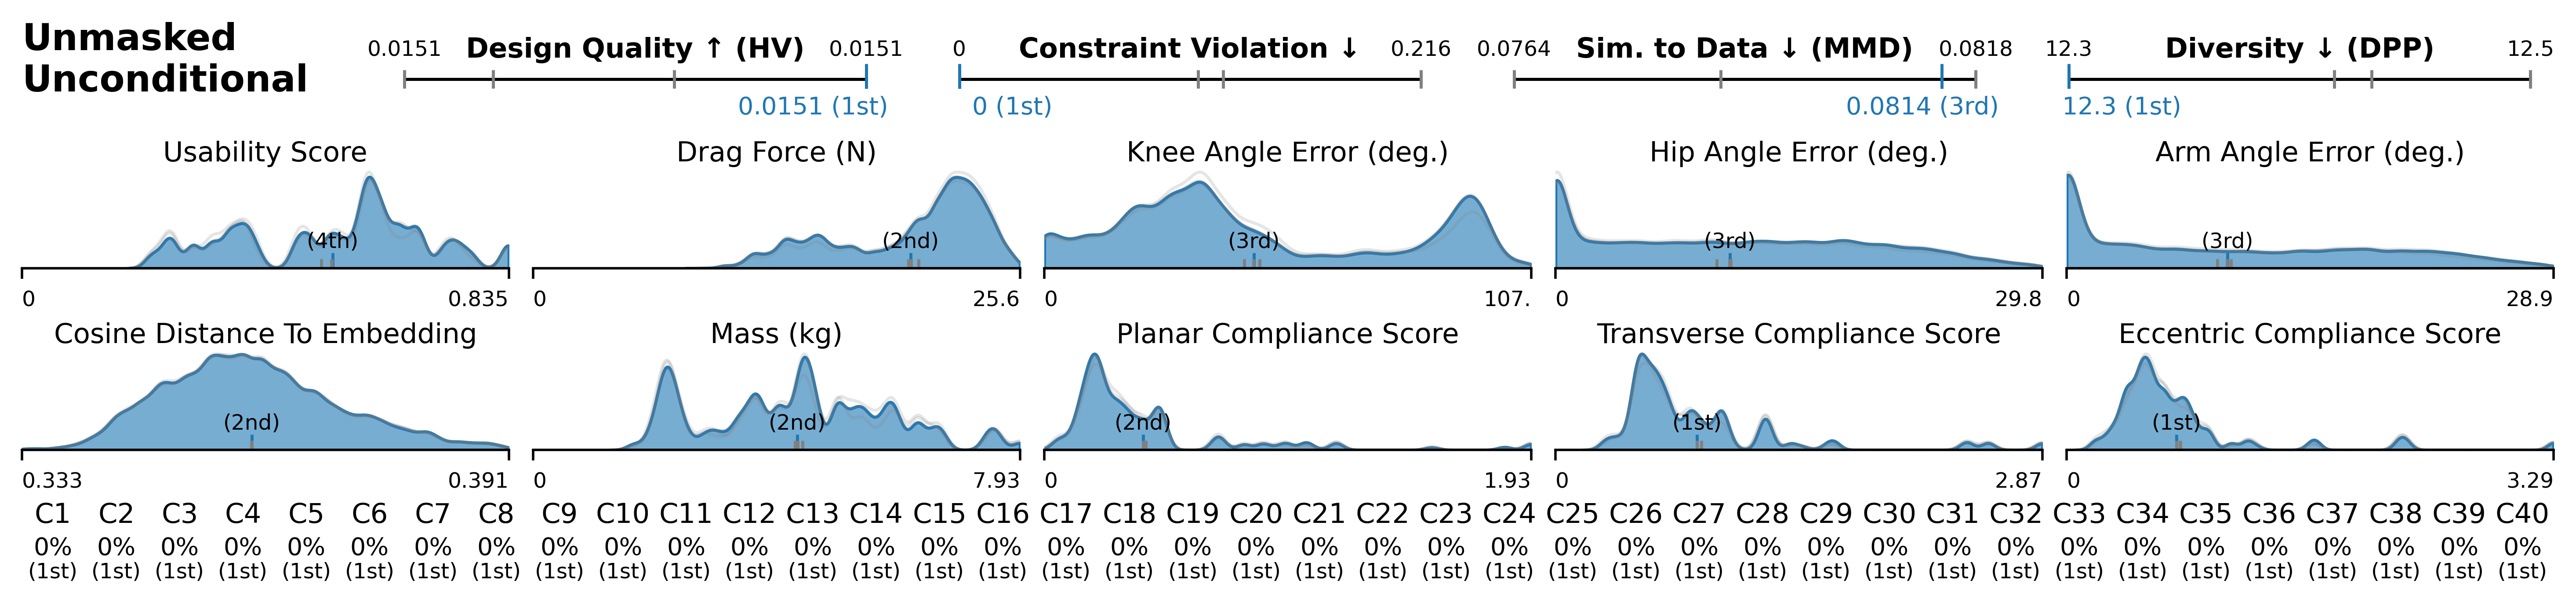

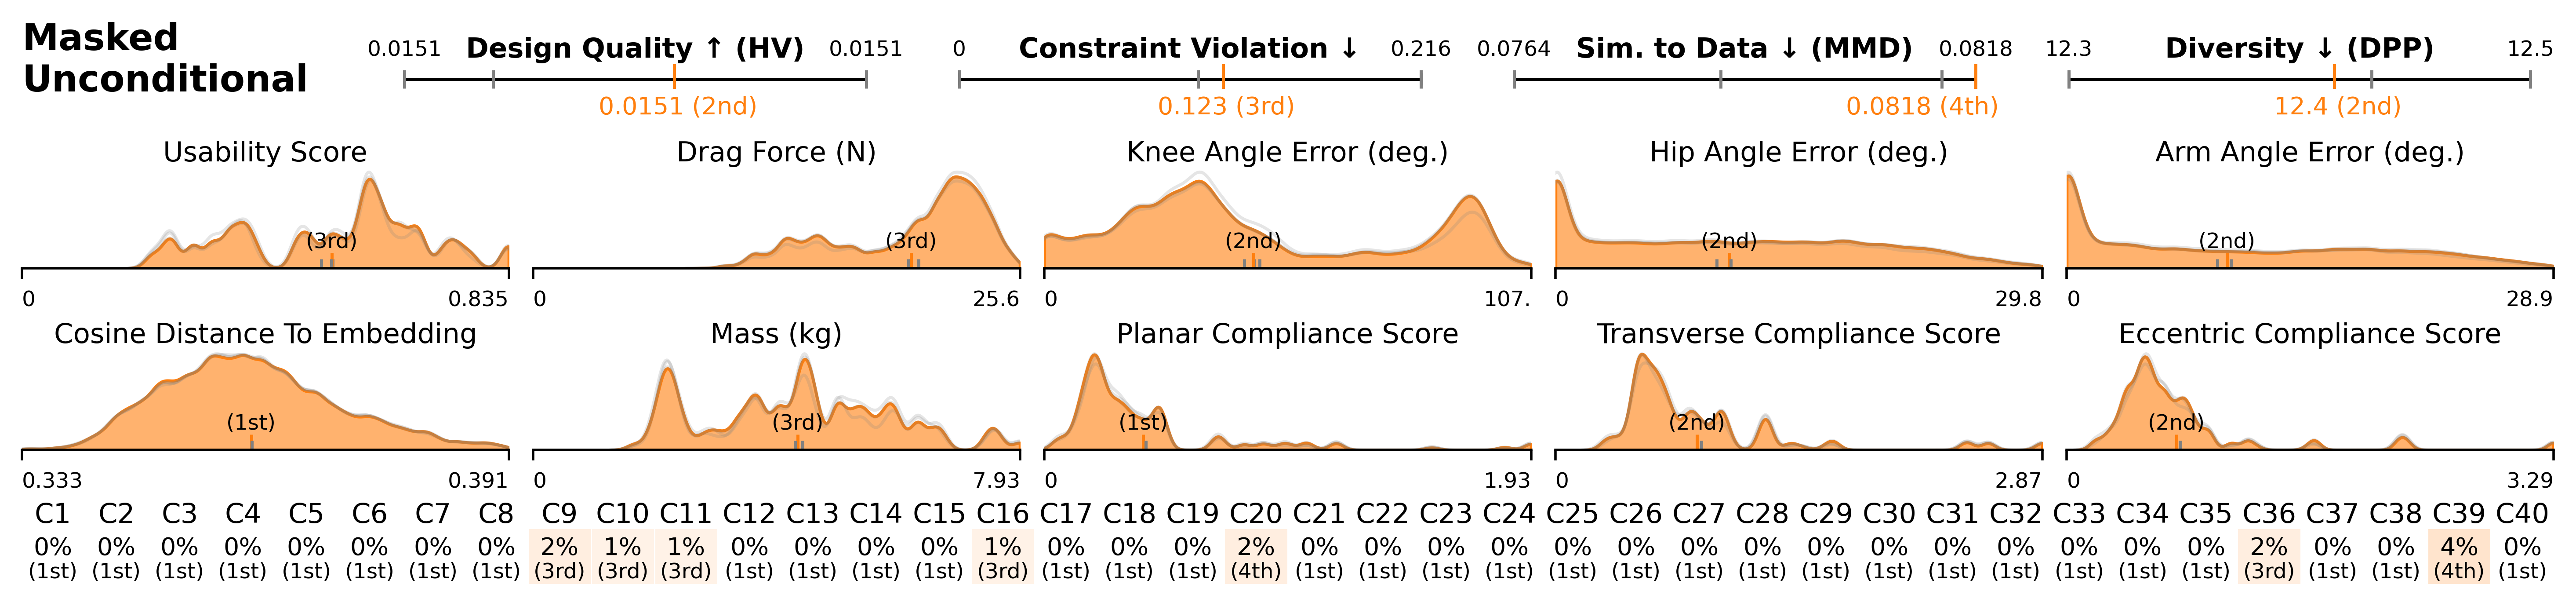

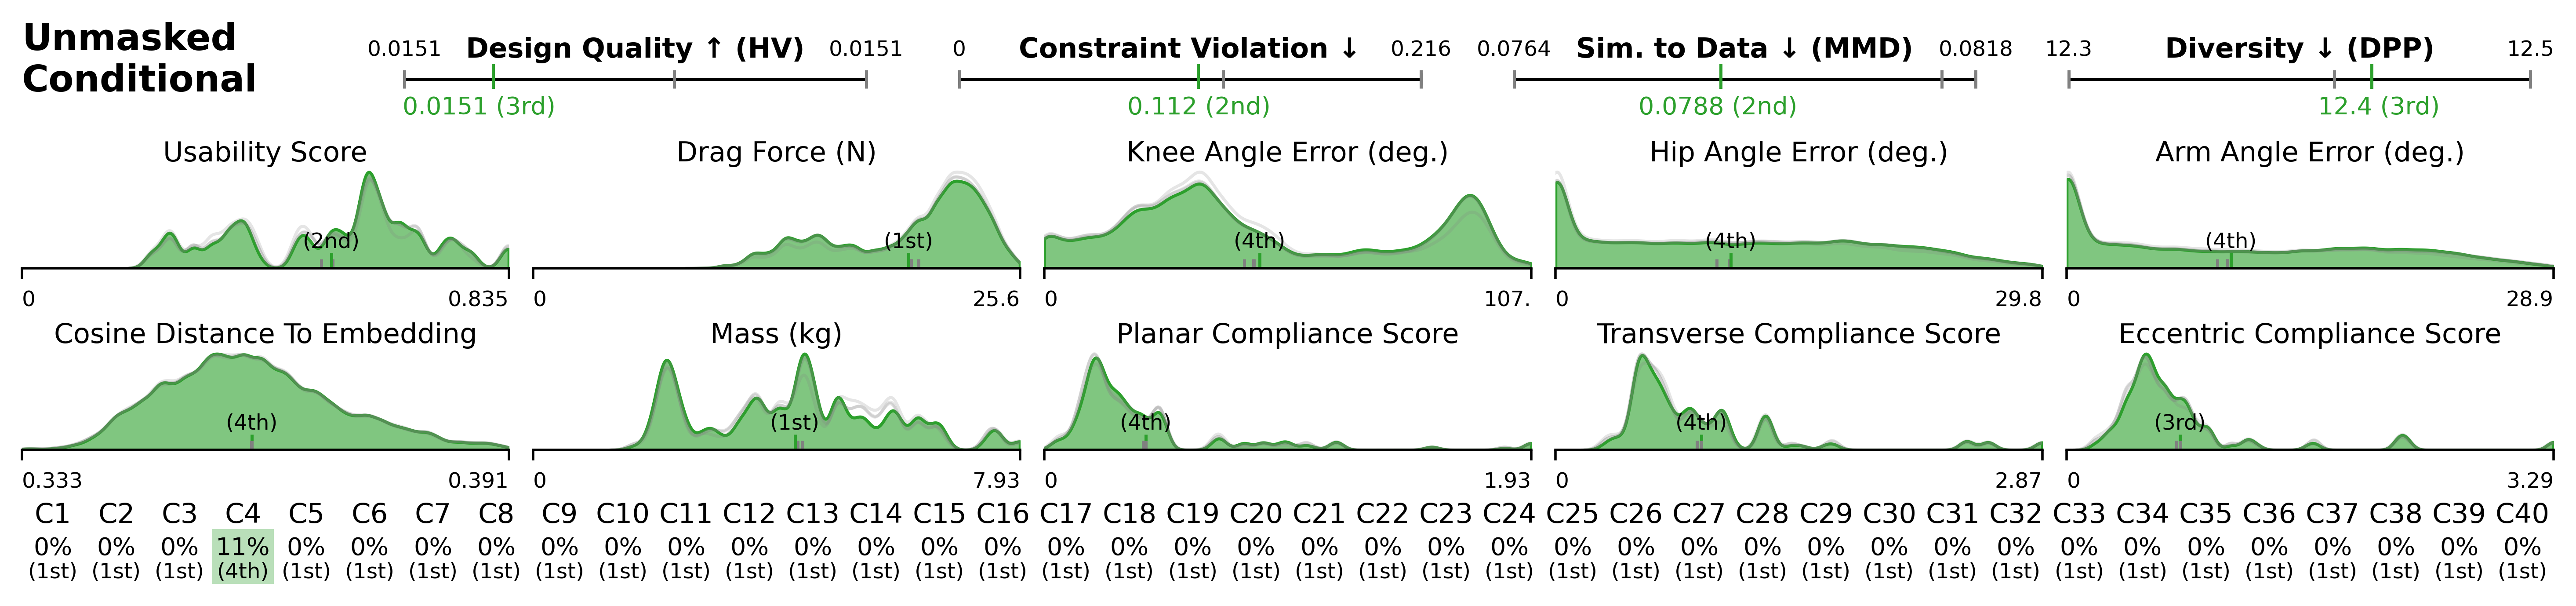

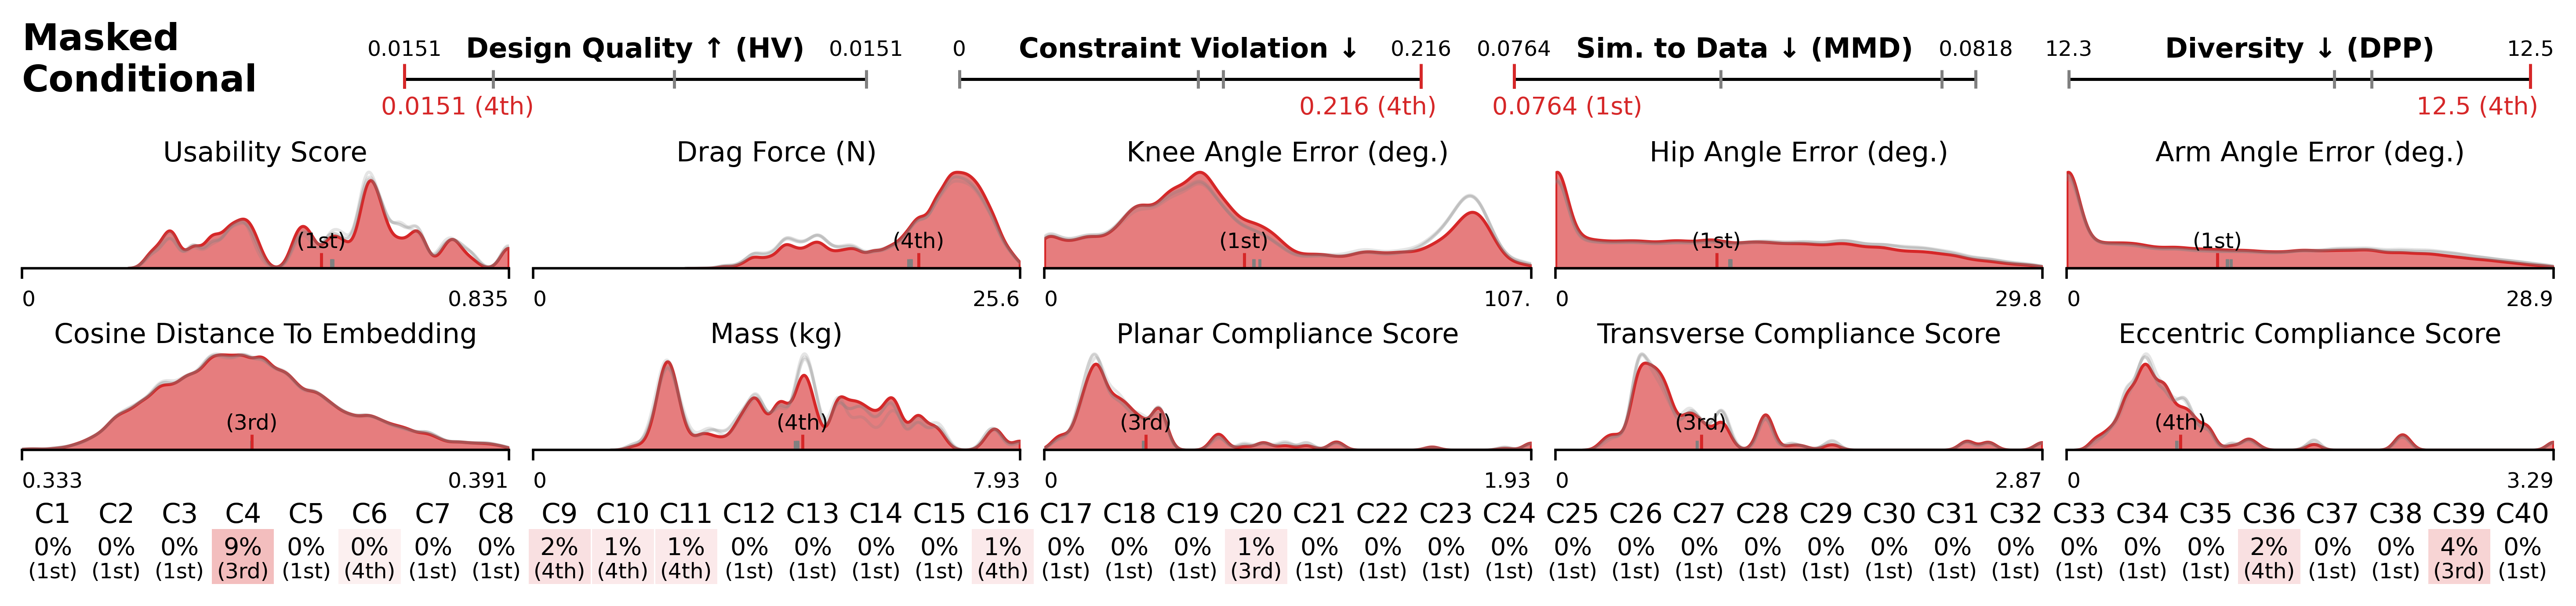

In [10]:
all_evaluation_scores_dict = {f"Unmasked Unconditional": all_evaluation_scores_unconditional,
                              f"Masked Unconditional": all_evaluation_scores_masked_unconditional,
                                f"Unmasked Conditional": all_evaluation_scores,
                                f"Masked Conditional": all_evaluation_scores_masked
                              }
main_scores_dict = {f"Unmasked Unconditional": main_scores_unconditional,
                    f"Masked Unconditional": main_scores_masked_unconditional,
                    f"Unmasked Conditional": main_scores,
                    f"Masked Conditional": main_scores_masked
                    }
dashboard = ScoreReportDashboard(
    requirement_scores=all_evaluation_scores_dict,
    overall_scores=main_scores_dict,
)

for m in all_evaluation_scores_dict.keys():
    dashboard.show_model(m)
